In [8]:
# Instalar librerías necesarias
!pip install geopandas cartopy xarray matplotlib cftime pandas

import os
import requests
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib.colors import BoundaryNorm
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Parámetros base
base_year = 2024
base_month = 11
base_date_str = f"{base_year}{base_month:02d}"

# Función para añadir meses a una fecha
def add_months_to_date(date, months):
    return date + relativedelta(months=months)

# Función para descargar archivos desde una URL
def download_file(url, local_path):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(local_path, "wb") as f:
            f.write(response.content)
        print(f"Descargado: {local_path}")
    else:
        print(f"Error al descargar {url}: {response.status_code}")
    return local_path

# Ruta base para los datos NetCDF y shapefiles
base_data_url = "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/data"
base_shape_url = "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape"
local_dir = "/content/data"
os.makedirs(local_dir, exist_ok=True)

# Archivos a descargar
files = {
    "mes_ensemble_tmax_peru": f"{base_data_url}/mes_ensemble_tmax_peru.nc",
    "prom_tmax_clima": f"{base_data_url}/prom.tmax.clima.nc",
    "mes_ensemble_tmin_peru": f"{base_data_url}/mes_ensemble_tmin_peru.nc",
    "prom_tmin_clima": f"{base_data_url}/prom.tmin.clima.nc",
    "peru_shp": f"{base_shape_url}/DEPARTAMENTOS.shp",
    "peru_dbf": f"{base_shape_url}/DEPARTAMENTOS.dbf",
    "peru_shx": f"{base_shape_url}/DEPARTAMENTOS.shx",
    "sudamerica_shp": f"{base_shape_url}/SUDA_NUEVO_SIN_PERU_3.shp",
    "sudamerica_dbf": f"{base_shape_url}/SUDA_NUEVO_SIN_PERU_3.dbf",
    "sudamerica_shx": f"{base_shape_url}/SUDA_NUEVO_SIN_PERU_3.shx"
}

# Descargar archivos
local_files = {}
for name, url in files.items():
    local_path = os.path.join(local_dir, os.path.basename(url))
    local_files[name] = download_file(url, local_path)

# Verificar que los shapefiles están completos
def verify_shapefile(base_name):
    for ext in ['.shp', '.dbf', '.shx']:
        file_path = base_name + ext
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Archivo necesario no encontrado: {file_path}")
        print(f"Verificado: {file_path}")

verify_shapefile(os.path.join(local_dir, "DEPARTAMENTOS"))
verify_shapefile(os.path.join(local_dir, "SUDA_NUEVO_SIN_PERU_3"))

# Rutas locales de los shapefiles
ruta_shapefile_peru = local_files["peru_shp"]
ruta_shapefile_sudamerica = local_files["sudamerica_shp"]

# Cargar shapefiles
peru = gpd.read_file(ruta_shapefile_peru)
sudamerica = gpd.read_file(ruta_shapefile_sudamerica)

# Función para graficar anomalías
def plot_anomaly(archivo_pronostico, archivo_climatologia, variable, output_name):
    # Abrir los archivos NetCDF sin decodificar el tiempo
    ds_pronostico = xr.open_dataset(archivo_pronostico, decode_times=False)
    ds_climatologia = xr.open_dataset(archivo_climatologia, decode_times=False)

    # Extraer la base temporal desde los atributos de 'time'
    time_units = ds_pronostico['time'].attrs['units']
    base_date_str = time_units.split('since')[-1].strip()
    base_date = datetime.strptime(base_date_str, "%Y-%m-%d %H:%M:%S")

    # Seleccionar el primer tiempo y calcular el promedio espacial
    pronostico_var = ds_pronostico[variable].isel(time=0).mean(dim='time')
    climatologia_var = ds_climatologia[variable].mean(dim='time')
    anomalia = pronostico_var - climatologia_var

    # Verificar dimensiones de la anomalía
    if len(anomalia.shape) != 2:
        anomalia = anomalia.isel(time=0)  # Asegurar trabajar con dimensiones 2D

    # Crear el gráfico
    plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    lon, lat = np.meshgrid(ds_pronostico['lon'], ds_pronostico['lat'])
    img = ax.pcolormesh(lon, lat, anomalia, cmap="coolwarm", shading='auto', transform=ccrs.PlateCarree())
    ax.set_extent([-81.5, -68.5, -18.5, 0.5], crs=ccrs.PlateCarree())
    peru.boundary.plot(ax=ax, edgecolor="black", linewidth=0.6)
    sudamerica.boundary.plot(ax=ax, edgecolor="black", linewidth=0.4)
    plt.title(f"Anomalía de {output_name} - {base_date.strftime('%Y-%m')}")
    plt.colorbar(img, ax=ax, orientation="vertical", pad=0.02)
    plt.show()

# Graficar Tmax
plot_anomaly(
    archivo_pronostico=local_files["mes_ensemble_tmax_peru"],
    archivo_climatologia=local_files["prom_tmax_clima"],
    variable="t",
    output_name="TempMax"
)

# Graficar Tmin
plot_anomaly(
    archivo_pronostico=local_files["mes_ensemble_tmin_peru"],
    archivo_climatologia=local_files["prom_tmin_clima"],
    variable="t",
    output_name="TempMin"
)


Descargado: /content/data/mes_ensemble_tmax_peru.nc
Descargado: /content/data/prom.tmax.clima.nc
Descargado: /content/data/mes_ensemble_tmin_peru.nc
Descargado: /content/data/prom.tmin.clima.nc
Descargado: /content/data/DEPARTAMENTOS.shp
Descargado: /content/data/DEPARTAMENTOS.dbf
Descargado: /content/data/DEPARTAMENTOS.shx
Descargado: /content/data/SUDA_NUEVO_SIN_PERU_3.shp
Descargado: /content/data/SUDA_NUEVO_SIN_PERU_3.dbf
Descargado: /content/data/SUDA_NUEVO_SIN_PERU_3.shx
Verificado: /content/data/DEPARTAMENTOS.shp
Verificado: /content/data/DEPARTAMENTOS.dbf
Verificado: /content/data/DEPARTAMENTOS.shx
Verificado: /content/data/SUDA_NUEVO_SIN_PERU_3.shp
Verificado: /content/data/SUDA_NUEVO_SIN_PERU_3.dbf
Verificado: /content/data/SUDA_NUEVO_SIN_PERU_3.shx


ValueError: 'time' not found in array dimensions ('lat', 'lon')

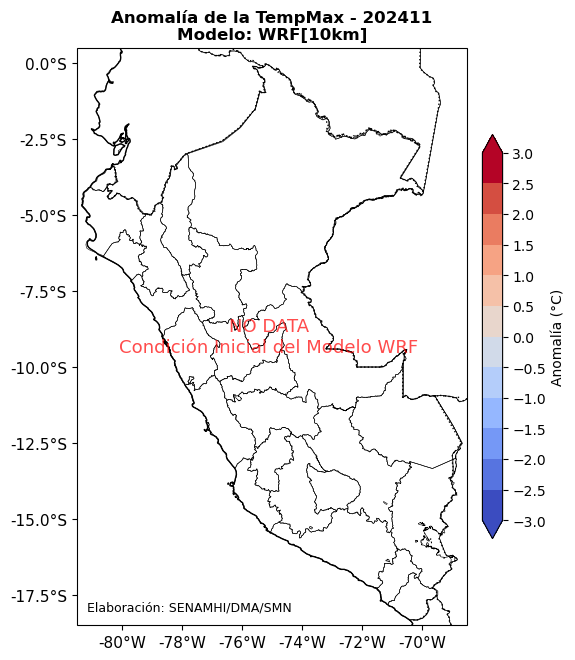

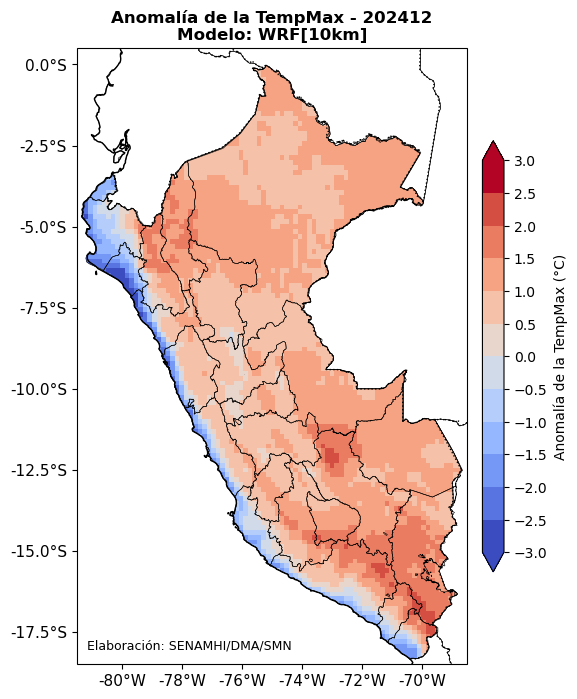

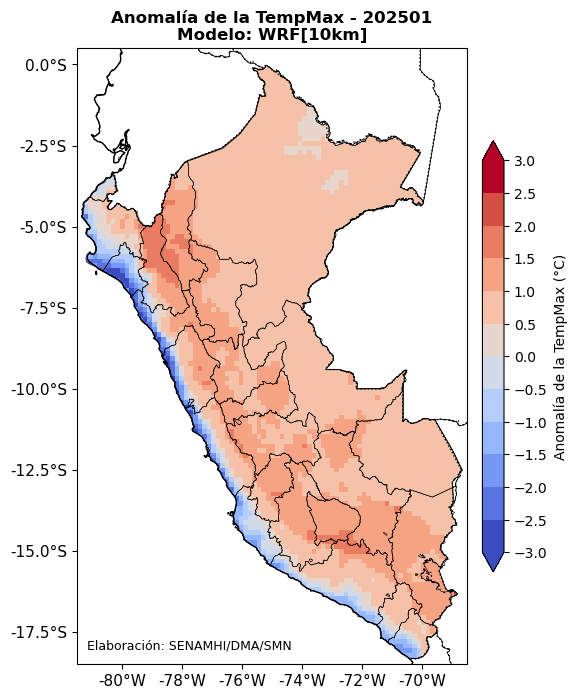

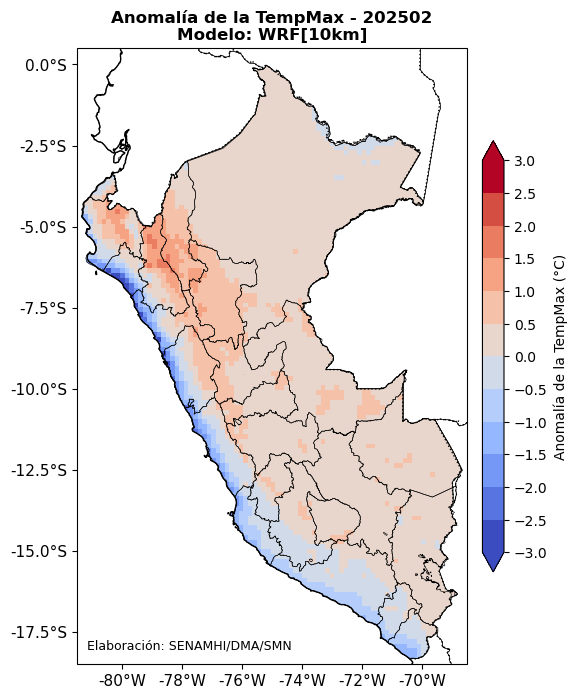

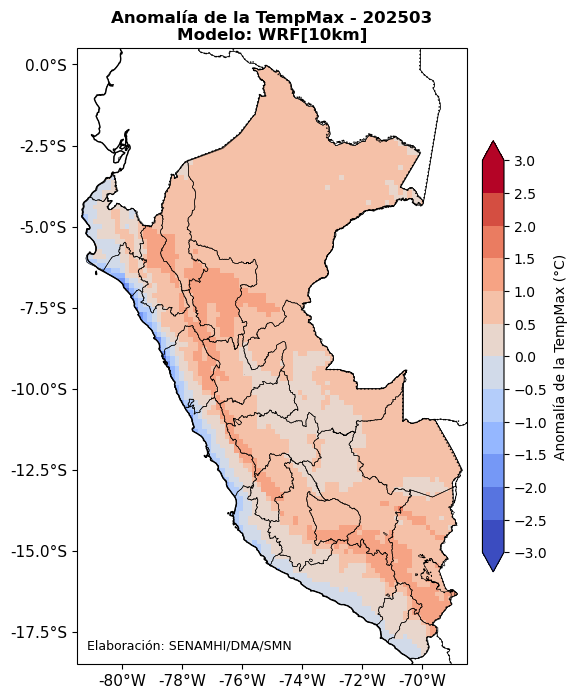

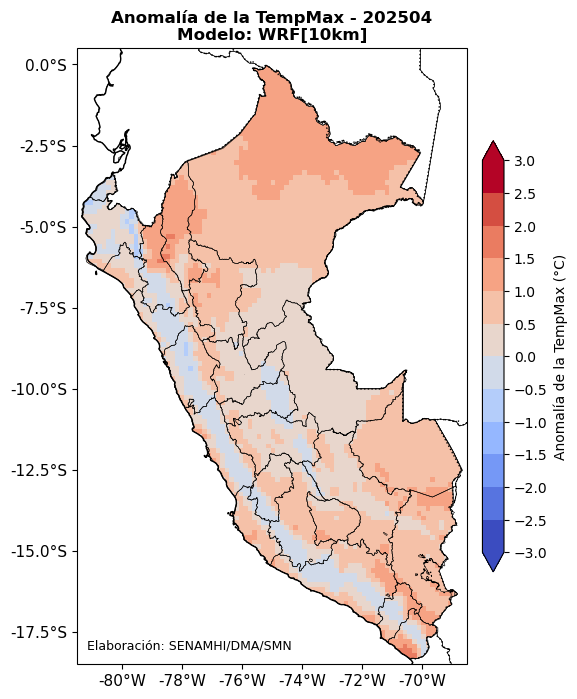

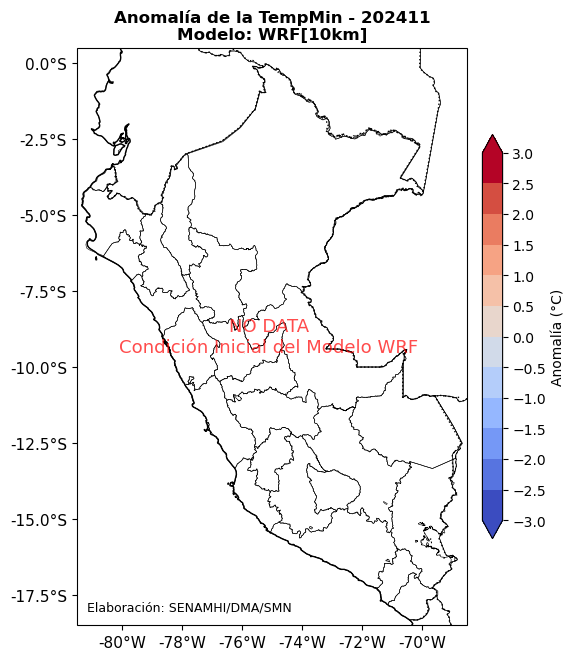

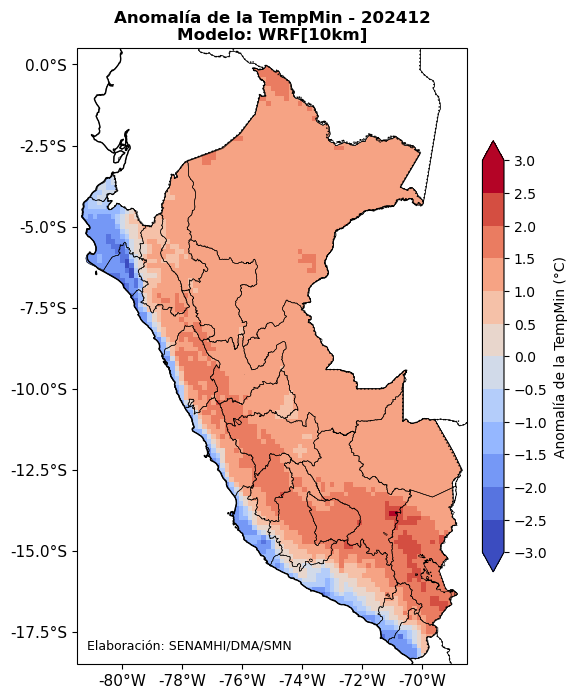

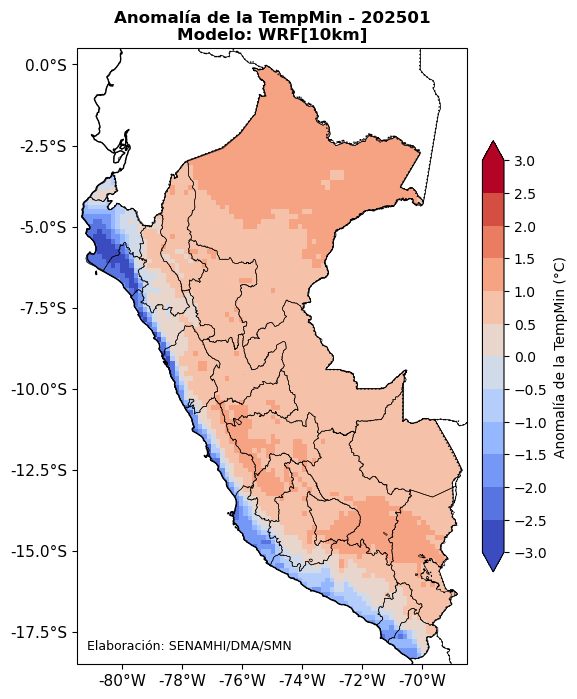

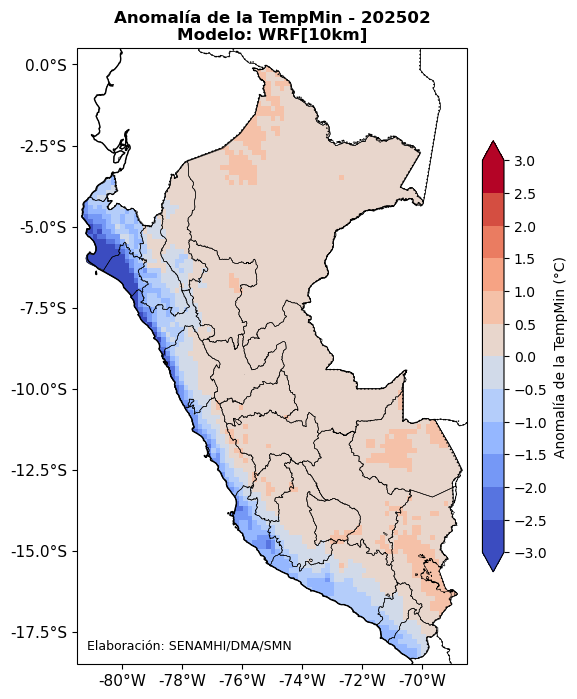

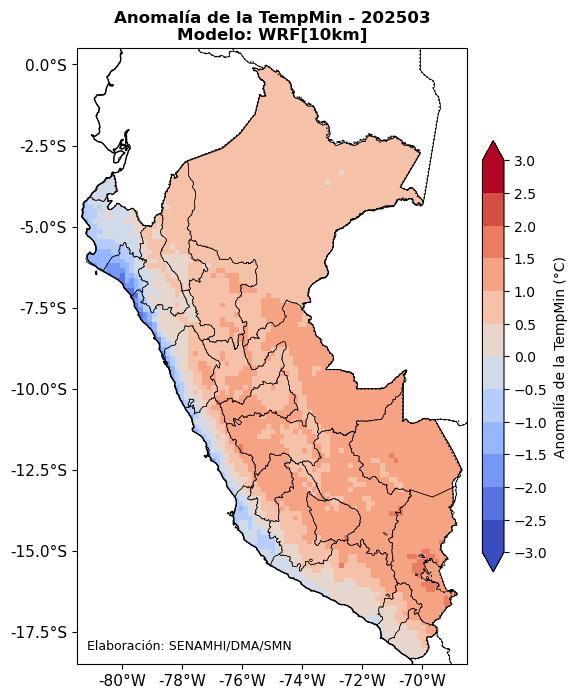

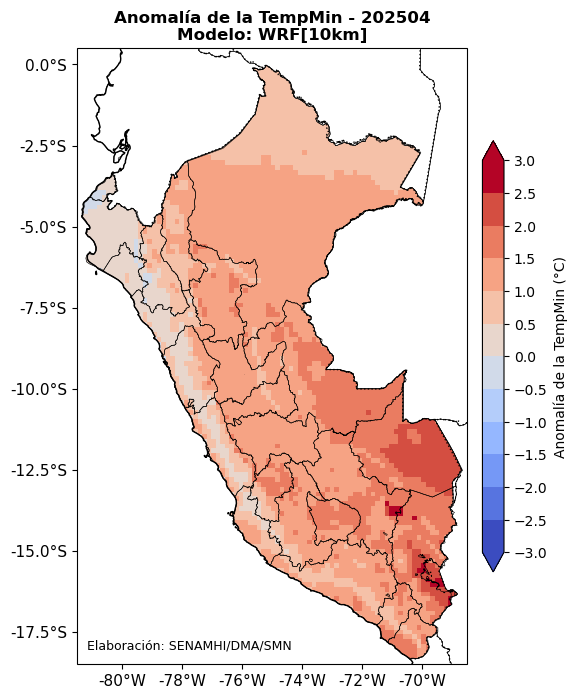

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import os
from matplotlib.colors import BoundaryNorm

base_year = 2024
base_month = 11
base_date_str = f"{base_year}{base_month:02d}"

# Función para añadir meses a una fecha
def add_months_to_date(date, months):
    return date + relativedelta(months=months)

def plot_anomaly(archivo_pronostico, archivo_climatologia, variable, output_name):
    # Abrir los archivos NetCDF sin decodificar el tiempo
    ds_pronostico = xr.open_dataset(archivo_pronostico, decode_times=False)
    ds_climatologia = xr.open_dataset(archivo_climatologia, decode_times=False)

    # Extraer el año y mes base desde los atributos de 'time'
    time_units = ds_pronostico['time'].attrs['units']
    fecha_base_str = time_units.split('since')[-1].strip()
    fecha_base = datetime.strptime(fecha_base_str, "%Y-%m-%d %H:%M:%S")

    # Acceder a las variables de temperatura máxima o mínima (variable 't')
    pronostico_var = ds_pronostico[variable]
    climatologia_var = ds_climatologia[variable]

    # Calcular la fecha del primer tiempo
    meses_desde_base = ds_pronostico['time'].isel(time=0).values
    fecha_primer_tiempo = add_months_to_date(fecha_base, int(meses_desde_base))

    # Crear la carpeta con el nombre basado en la fecha del mes anterior al primer tiempo
    fecha_anterior = add_months_to_date(fecha_primer_tiempo, -1)
    carpeta_anterior = f'{fecha_anterior.year}{fecha_anterior.month:02d}'
    ruta_carpeta = f'/scratch/DMA/SMN/CLIMA/web_figuras/prediccion/mensual/{carpeta_anterior}'

    if not os.path.exists(ruta_carpeta):
        os.makedirs(ruta_carpeta)

    # Crear colormap BrBG discreto con 13 niveles
    cmap = plt.get_cmap('coolwarm', 12)
    norm = BoundaryNorm(np.arange(-3, 3.5, 0.5), cmap.N)

    # Graficar la imagen de "NO DATA" para la fecha carpeta_anterior
    plt.figure(figsize=(10, 7.5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-81.5, -68.5, -18.5, 0.5], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Añadir shapefiles de Sudamérica y Perú
    sudamerica.boundary.plot(ax=ax, edgecolor='black', linewidth=0.4)
    peru.boundary.plot(ax=ax, edgecolor='black', linewidth=0.4)

    # Añadir la barra de colores con los valores de -3 a 3
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02, ticks=np.arange(-3, 4, 0.5), extend='both',shrink=0.7, aspect=20)
    cbar.set_label('Anomalía (°C)')

    # Configurar las etiquetas de latitud y longitud
    ax.set_xticks(np.arange(-80, -68, 2), crs=ccrs.PlateCarree())  # Longitudes
    ax.set_yticks(np.arange(-17.5, 2.5, 2.5), crs=ccrs.PlateCarree())  # Latitudes
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}°W'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y}°S'))
    # Ajustar el tamaño de la fuente de los ticks en los ejes
    ax.tick_params(axis='both', which='major', labelsize=11)  # Cambia el valor
    # Añadir el texto "NO DATA"
    ax.text(0.5, 0.5, 'NO DATA \nCondición Inicial del Modelo WRF ',
            horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, fontsize=13, color='red', alpha=0.7)

    # Añadir la leyenda de texto en la parte inferior derecha
    ax.text(0.55, 0.02, 'Elaboración: SENAMHI/DMA/SMN', horizontalalignment='right',
            verticalalignment='bottom', transform=ax.transAxes, fontsize=9, color='black',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    plt.title(f'Anomalía de la {output_name} - {carpeta_anterior}\nModelo: WRF[10km]', fontsize=12, fontweight='bold')
    ruta_archivo = os.path.join(ruta_carpeta, f'pre_smnwrf_{carpeta_anterior}_anom{output_name}_wrf.png')
    plt.savefig(ruta_archivo, dpi=300, bbox_inches='tight')
    plt.show()

    # Graficar las anomalías para los primeros 5 tiempos
    for i in range(5):
        # Calcular la fecha real sumando los meses al tiempo base
        meses_desde_base = ds_pronostico['time'].isel(time=i).values
        fecha_real = add_months_to_date(fecha_base, int(meses_desde_base))
        year = fecha_real.year
        month = fecha_real.month

        # Formatear la fecha en formato YYYYMM
        fecha_str = f'{year}{month:02d}'

        # Seleccionar el tiempo correspondiente en ambos datasets
        pronostico_var_t = pronostico_var.isel(time=i)
        climatologia_var_t = climatologia_var.isel(time=i)

        # Calcular la anomalía para el tiempo actual
        anomalia_var_t = pronostico_var_t - climatologia_var_t

        # Crear el gráfico de la anomalía
        plt.figure(figsize=(10, 8))
        ax = plt.axes(projection=ccrs.PlateCarree())

        # Definir los límites geográficos para Perú
        lon_min, lon_max = -81.5, -68.5
        lat_min, lat_max = -18.5, 0.5

        # Graficar la anomalía
        img = anomalia_var_t.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)

        # Configurar los límites del mapa para Perú
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

        # Añadir líneas de costa y fronteras
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        # Añadir shapefiles de Sudamérica y Perú
        sudamerica.boundary.plot(ax=ax, edgecolor='black', linewidth=0.4)
        peru.boundary.plot(ax=ax, edgecolor='black', linewidth=0.4)

        # Añadir shapefile de Sudamérica sin Perú
        sudamerica_noperu = gpd.read_file(ruta_shapefile_sudamerica)
        sudamerica_noperu.plot(ax=ax, edgecolor='black', facecolor='white', linewidth=0.1, zorder=1)

        # Añadir la barra de colores con los valores de -3 a 3 y frecuencia de 0.5
        cbar = plt.colorbar(img, ax=ax, orientation='vertical', pad=0.02, ticks=np.arange(-3, 4, 0.5), extend='both', shrink=0.7, aspect=20)
        cbar.set_label(f'Anomalía de la {output_name} (°C)')

        # Configurar las etiquetas de latitud y longitud en los ejes
        ax.set_xticks(np.arange(-80, -68, 2), crs=ccrs.PlateCarree())  # Longitudes
        ax.set_yticks(np.arange(-17.5, 2.5, 2.5), crs=ccrs.PlateCarree())  # Latitudes
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}°W'))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y}°S'))
        # Ajustar el tamaño de la fuente de los ticks en los ejes
        ax.tick_params(axis='both', which='major', labelsize=11)  # Cambia el valor

        # Añadir nombres a los ejes
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Añadir la leyenda de texto en la parte inferior derecha
        ax.text(0.55, 0.02, 'Elaboración: SENAMHI/DMA/SMN', horizontalalignment='right',
                verticalalignment='bottom', transform=ax.transAxes, fontsize=9, color='black',
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

        # Añadir el título utilizando la fecha en formato YYYYMM
        plt.title(f'Anomalía de la {output_name} - {fecha_str}\nModelo: WRF[10km]', fontsize=12, fontweight='bold')

        # Guardar el gráfico en la carpeta creada
        nombre_archivo = f'pre_smnwrf_{fecha_str}_anom{output_name}_wrf.png'
        ruta_archivo = os.path.join(ruta_carpeta, nombre_archivo)
        plt.savefig(ruta_archivo, dpi=300, bbox_inches='tight')

        # Mostrar el gráfico
        plt.show()

# Shapefiles para Sudamérica y Perú
ruta_shapefile_sudamerica = '/scratch/shape/SHAPES/SUDA_NUEVO_SIN_PERU_3.shp'
ruta_shapefile_peru = '/scratch/shape/PER/DEPARTAMENTOS.shp'
sudamerica = gpd.read_file(ruta_shapefile_sudamerica)
peru = gpd.read_file(ruta_shapefile_peru)

# Graficar Tmax
plot_anomaly(
    archivo_pronostico=f"/scratch/DMA/SMN/CLIMA/c3s_cfsv2/wrf391/wrf_post/{base_year}/{base_month}/tmax.tmin/mes_ensemble_tmax_peru.nc",
    archivo_climatologia=f"/scratch/DMA/SMN/CLIMA/enandes/respaldo/BKrespaldo/CLUSTER-COMPLEMENTARIO/EXTRACCION-CLIM/{base_month}-1982.2010/tmax.tmin/prom.tmax.clima.nc",
    variable="t",
    output_name="TempMax"
)

# Graficar Tmin
plot_anomaly(
    archivo_pronostico=f"/scratch/DMA/SMN/CLIMA/c3s_cfsv2/wrf391/wrf_post/{base_year}/{base_month}/tmax.tmin/mes_ensemble_tmin_peru.nc",
    archivo_climatologia=f"/scratch/DMA/SMN/CLIMA/enandes/respaldo/BKrespaldo/CLUSTER-COMPLEMENTARIO/EXTRACCION-CLIM/{base_month}-1982.2010/tmax.tmin/prom.tmin.clima.nc",
    variable="t",
    output_name="TempMin"
)
